# Utils

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [49]:
from lab1_utils import train_loop
from lab1_utils import multiple_diagnostic

Define 3 networks to test over the dataset

In [6]:
class Net1(nn.Module):
    def __init__(self):
        """ from torch.docs
            torch.nn.Linear(in_features, out_features, bias=True, device=None,
                            dtype=None)
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1,
                            padding=0, dilation=1, groups=1, bias=True,
                            padding_mode='zeros', device=None, dtype=None)
            torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1,
                               return_indices=False, ceil_mode=False)
        """
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x.shape B, N, H, W
        ## Convolution layers
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        ## Network layers
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)  # output the logits

        ## Log-softmax for Negative-Log_likelihood
        output = F.log_softmax(x, dim=1)
        return output

In [5]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x.shape B, N, H, W
        ## Convolution layers
        x = self.relu(self.conv1(x))
        # print(x.shape)
        x = self.pool(x)
        # print(x.shape)
        x = self.relu(self.conv2(x))
        # print(x.shape)
        x = self.pool(x)
        # print(x.shape)
        ## Network layers
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.relu(self.fc1(x))
        # print(x.shape)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output

In [52]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x.shape B, N, H, W
        ## Convolution layers
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        # print(x.shape)
        ## Network layers
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        # la log(softmax) serve poi in fase di calcolo della CE loss
        output = F.log_softmax(x, dim=1)
        return output

In [53]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = "MLP"
        self.fc1 = nn.Linear(28*28, 700)
        self.fc2 = nn.Linear(700, 500)
        self.fc3 = nn.Linear(500, 250)
        self.fc4 = nn.Linear(250, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        output = F.log_softmax(x, dim=1)
        return output

In [11]:
criterion = nn.NLLLoss()

In [4]:
# TODO: remove
def train(model, device, train_loader, optimizer, epoch, info=True):
    # ogni layer può avere un comportamento a seconda di training o test
    # esempio è il dropout, batch normalization
    model.train()  # configura il modello in training mode

    losses, accs = [], []
    correct = 0.

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        ## Make a step
        optimizer.zero_grad()
        output = model(data)

        loss = F.nll_loss(output, target)  # compute loss
        loss.backward()  # compute gradient
        optimizer.step()  # update weights

        ## Prediction
        pred = output.argmax(dim=1, keepdim=True)
        correct = torch.eq(pred, target.view_as(pred)).float()
        acc = torch.mean(correct)

        ## Update loss and accuracy
        losses.append(loss.detach().cpu().numpy())
        # mi sa anche loss.item()
        accs.append(acc.detach().cpu().numpy())

        # if batch_idx % 500 == 0:
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(train_loader.dataset),
        #         100. * batch_idx / len(train_loader), loss.item()))
        if info:
            if batch_idx % 500 == 0:
                print(f"Train epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]",
                      f"Loss: {loss.item():.4f}",
                      f"Accuracy: {100 * acc:.1f}%"
                      )

    loss_k = np.array(losses).mean()
    acc_k = np.array(accs).mean()

    return loss_k, acc_k

In [5]:
# TODO: remove
def test(model, device, test_loader, info=True):
    model.eval()  # configura il modello in evaluation mode

    losses, accs = [], []
    correct = 0.

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            ## Compute loss
            output = model(data)
            loss = F.nll_loss(output, target)
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            ## Prediction
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct = torch.eq(pred, target.view_as(pred)).float()
            # correct += pred.eq(target.view_as(pred)).sum().item()
            acc = torch.mean(correct)

            ## Update loss and accuracy
            losses.append(loss.detach().cpu().numpy())
            accs.append(acc.detach().cpu().numpy())


    # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #     test_loss, correct, len(test_loader.dataset),
    #     100. * correct / len(test_loader.dataset)))

    # test_loss /= len(test_loader.dataset)
    # accuracy /= len(test_loader.dataset)
    loss_k = np.array(losses).mean()
    acc_k = np.array(accs).mean()

    if info:
        # after each epoch
        print(f"Test set - Loss: {loss_k:.4f} - Accuracy: {100 * acc_k:.1f}%")

    return loss_k, acc_k

In [47]:
# TODO: remove
def train_loop(train_loader, test_loader, model, device, lr, momentum,
               nesterov, max_epochs, info=True, do_test=True):

    model.to(device)
    print(f"Training {model.net}")

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum,
                          nesterov=nesterov)
    
    losses_train, accs_train = [], []
    losses_test, accs_test = [], []
    
    epochs = max_epochs
    _start = time.time()
    _epoch_time = time.time()
    for epoch in range(1, epochs + 1):
        loss_train, acc_train = train(model, device, train_loader, optimizer,
                                      epoch, info)
        print(f"Epoch: {epoch}")
        print(f"Training - Loss: {loss_train:.4f}, Accuracy: {acc_train:.2f}, Runtime: {(time.time() - _epoch_time):.2f}")
        losses_train.append(loss_train)
        accs_train.append(acc_train)

        if do_test:
            loss_test, acc_test = test(model, device, test_loader, info)
            losses_test.append(loss_test)
            accs_test.append(acc_test)
            print(f"Test - Loss: {loss_test:.4f}, Accuracy: {acc_test:.2f}")
        _epoch_time = time.time()
    _end = time.time()
    print(f"Done! - Runtime: {(_end-_start):.2f} seconds")

    if do_test:
        return losses_train, accs_train, losses_test, accs_test
    else:
        return losses_train, accs_train

In [14]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
      ])

trainset = datasets.MNIST('./data', train=True, download=True, transform=transform)
testset = datasets.MNIST('./data', train=False, transform=transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(trainset, num_workers=2, pin_memory=True, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(testset, num_workers=2, pin_memory=True, shuffle=True, batch_size=batch_size)

In [31]:
model1 = Net1()
print(model1(torch.randn(1, 1, 28, 28)))
print(summary(model1))

tensor([[-2.3410, -2.4122, -2.3046, -2.2851, -2.4119, -2.2537, -2.2184, -2.2727,
         -2.2334, -2.3130]], grad_fn=<LogSoftmaxBackward0>)
Layer (type:depth-idx)                   Param #
Net1                                     --
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            18,496
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            1,179,776
├─Linear: 1-5                            1,290
├─ReLU: 1-6                              --
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0


In [22]:
model2 = Net2()
print(model2(torch.randn(1, 1, 28, 28)))
print(summary(model2))

tensor([[-2.1285, -2.3810, -2.1887, -2.2953, -2.5300, -2.0858, -2.4472, -2.3244,
         -2.3162, -2.4208]], grad_fn=<LogSoftmaxBackward0>)
Layer (type:depth-idx)                   Param #
Net2                                     --
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            18,496
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            204,928
├─Linear: 1-5                            1,290
├─ReLU: 1-6                              --
Total params: 225,034
Trainable params: 225,034
Non-trainable params: 0


In [42]:
model3 = Net3()
print(model3(torch.randn(1, 1, 28, 28)))
print(summary(model3))

torch.Size([1, 32, 12, 12])
tensor([[-2.2415, -2.1380, -2.3563, -2.2355, -2.3368, -2.3631, -2.3551, -2.3739,
         -2.2818, -2.3727]], grad_fn=<LogSoftmaxBackward0>)
Layer (type:depth-idx)                   Param #
Net3                                     --
├─Conv2d: 1-1                            416
├─Conv2d: 1-2                            12,832
├─MaxPool2d: 1-3                         --
├─Linear: 1-4                            589,952
├─Linear: 1-5                            8,256
├─Linear: 1-6                            650
├─ReLU: 1-7                              --
Total params: 612,106
Trainable params: 612,106
Non-trainable params: 0


In [54]:
model4 = MLP()
print(model4(torch.randn(1, 1, 28, 28)))
print(summary(model4))

tensor([[-2.3185, -2.3295, -2.3295, -2.3295, -2.3295, -2.2693, -2.2505, -2.2408,
         -2.3295, -2.3049]], grad_fn=<LogSoftmaxBackward0>)
Layer (type:depth-idx)                   Param #
MLP                                      --
├─Linear: 1-1                            549,500
├─Linear: 1-2                            350,500
├─Linear: 1-3                            125,250
├─Linear: 1-4                            2,510
├─ReLU: 1-5                              --
Total params: 1,027,760
Trainable params: 1,027,760
Non-trainable params: 0


# Exercise 0

In [8]:
# TODO: remove
def simple_diagnostic(max_epochs, losses_train, accs_train):
    epochs_seq = np.arange(1, max_epochs + 1)
    # epoch_labels = 

    # plot only training loss and accuracy
    fig, ax = plt.subplots()
    # fig.suptitle("Training performance")
    fig.suptitle("Training loss and accuracy againts epochs")

    color = "tab:blue"
    ax.plot(epochs_seq, losses_train, label="loss", color=color)
    # ax.set_title("Training loss and accuracy againts epochs")
    ax.grid("both")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss", color=color)
    ax.tick_params(axis="y", labelcolor=color)
    ax.set_xticks(np.arange(1, max_epochs+1, step=2))
    ax.set_xticklabels(np.arange(1, max_epochs + 1, 2))

    color = "tab:red"
    ax_1 = ax.twinx()
    ax_1.plot(epochs_seq, accs_train, label="accuracy", color="tab:red")
    ax_1.set_ylabel("Accuracy", color="tab:red")
    ax_1.tick_params(axis="y", labelcolor=color)

In [13]:
# TODO: remove
def diagnostic(max_epochs, losses_train, accs_train, losses_test, accs_test):
    ## left side training performance
    ## right side test performance
    epochs_seq = np.arange(1, max_epochs + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4), layout="constrained")
    fig.suptitle("CNN performance over MNIST")

    ## 1) train loss (first y axis) and accuracy (second y axis)
    color = "tab:blue"
    axs[0].plot(epochs_seq, losses_train, label="loss", color=color)
    axs[0].set_title("Training loss and accuracy againts epochs")
    axs[0].grid("both")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss", color=color)
    axs[0].tick_params(axis="y", labelcolor=color)

    color = "tab:red"
    axs0_1 = axs[0].twinx()
    axs0_1.plot(epochs_seq, accs_train, label="accuracy", color="tab:red")
    axs0_1.set_ylabel("Accuracy", color="tab:red")
    axs0_1.tick_params(axis="y", labelcolor=color)

    ## 2) test loss (first y axis) and accuracy (second y axis)
    color = "tab:blue"
    axs[1].plot(epochs_seq, losses_test, label="loss", color=color)
    axs[1].set_title("Test loss and accuracy againts epochs")
    axs[1].grid("both")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss", color=color)
    axs[1].tick_params(axis="y", labelcolor=color)

    color = "tab:red"
    axs1_1 = axs[1].twinx()
    axs1_1.plot(epochs_seq, accs_test, label="accuracy", color="tab:red")
    axs1_1.set_ylabel("Accuracy", color="tab:red")
    axs1_1.tick_params(axis="y", labelcolor=color)

In [10]:
# TODO: remove
def multiple_diagnostic_single(loss_acc_dict, max_epochs=10):
    # loss_acc_dict = {"Solver1": [loss, acc]...}
    epochs_seq = np.arange(1, max_epochs + 1)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

    fig, ax = plt.subplots()
    ax_1 = ax.twinx()
    # fig.suptitle("CNN training performance over CIFAR10")
    fig.suptitle("Training loss and accuracy againts epochs")

    for i, (solver_name, perf) in enumerate(loss_acc_dict.items()):

        color = colors[i]
        ## plot loss function performance
        ax.plot(epochs_seq, perf[0], label=solver_name, color=color)
        ax.grid("both")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")
        ax.tick_params(axis="y")
        ax.set_xticks(np.arange(1, max_epochs+1, step=2))
        ax.set_xticklabels(np.arange(1, max_epochs + 1, 2))

        ## plot accuracy performance
        ax_1.plot(epochs_seq, perf[1], label=solver_name, color=color)
        ax_1.set_ylabel("Accuracy")
        ax_1.tick_params(axis="y")

    ax.legend()

In [21]:
# TODO: remove
def multiple_diagnostic(loss_acc_dict, max_epochs=10, title_left="Training loss against epochs",
                       title_right="Test accuracy against epochs"):
    # loss_acc_dict = {"Solver1": [loss, acc]...}
    epochs_seq = np.arange(1, max_epochs + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4), layout="constrained")
    # fig.suptitle("CNN training performance over CIFAR10")

    for solver_name, perf in loss_acc_dict.items():

        # plot loss function performance
        axs[0].plot(epochs_seq, perf[0], label=solver_name)
        axs[0].grid("both")
        axs[0].set_title(title_left)

        # plot accuracy performance
        axs[1].plot(epochs_seq, perf[1], label=solver_name)
        axs[1].grid("both")
        axs[1].set_title(title_right)

    axs[0].legend()
    axs[1].legend()

In [47]:
max_epochs = 10
loss_acc_dict = {}

In [48]:
model1 = Net1()
model1.to(device)

model1_dict = dict(model=model1, criterion=criterion, device=device, lr=0.001, momentum=0.,
                   max_epochs=max_epochs, do_test=True)

# losses_train, accs_train, losses_test, accs_test
stats = train_loop(train_loader, test_loader, **model1_dict)
loss_acc_dict["Net1"] = [stats[0], stats[3]]

Epoch: 1, Learning rate: 0.001000
Training - Loss: 1.6375, Accuracy: 0.64, Runtime: 6.68
Test - Loss: 0.6140, Accuracy: 0.85
Epoch: 2, Learning rate: 0.001000
Training - Loss: 0.4482, Accuracy: 0.88, Runtime: 6.30
Test - Loss: 0.3491, Accuracy: 0.90
Epoch: 3, Learning rate: 0.001000
Training - Loss: 0.3436, Accuracy: 0.90, Runtime: 6.29
Test - Loss: 0.3055, Accuracy: 0.91
Epoch: 4, Learning rate: 0.001000
Training - Loss: 0.3090, Accuracy: 0.91, Runtime: 6.32
Test - Loss: 0.2792, Accuracy: 0.92
Epoch: 5, Learning rate: 0.001000
Training - Loss: 0.2837, Accuracy: 0.92, Runtime: 6.37
Test - Loss: 0.2661, Accuracy: 0.92
Epoch: 6, Learning rate: 0.001000
Training - Loss: 0.2620, Accuracy: 0.92, Runtime: 6.43
Test - Loss: 0.2388, Accuracy: 0.93
Epoch: 7, Learning rate: 0.001000
Training - Loss: 0.2423, Accuracy: 0.93, Runtime: 6.33
Test - Loss: 0.2223, Accuracy: 0.94
Epoch: 8, Learning rate: 0.001000
Training - Loss: 0.2249, Accuracy: 0.93, Runtime: 6.30
Test - Loss: 0.2052, Accuracy: 0.94


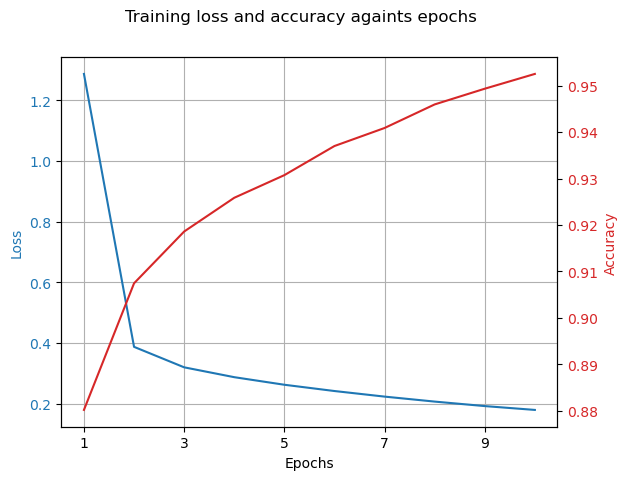

In [17]:
simple_diagnostic(10, stats[0], stats[3])

 # Exercise 1

Try different architectures

In [50]:
model2 = Net2()
model2.to(device)

model2_dict = dict(model=model2, criterion=criterion, device=device, lr=0.001, momentum=0.,
                   max_epochs=max_epochs, do_test=True)

stats = train_loop(train_loader, test_loader, **model2_dict)
loss_acc_dict["Net2"] = [stats[0], stats[3]]

Epoch: 1, Learning rate: 0.001000
Training - Loss: 1.9873, Accuracy: 0.53, Runtime: 5.15
Test - Loss: 1.3371, Accuracy: 0.78
Epoch: 2, Learning rate: 0.001000
Training - Loss: 0.7732, Accuracy: 0.83, Runtime: 5.06
Test - Loss: 0.4797, Accuracy: 0.87
Epoch: 3, Learning rate: 0.001000
Training - Loss: 0.4252, Accuracy: 0.88, Runtime: 5.12
Test - Loss: 0.3566, Accuracy: 0.90
Epoch: 4, Learning rate: 0.001000
Training - Loss: 0.3460, Accuracy: 0.90, Runtime: 5.18
Test - Loss: 0.3039, Accuracy: 0.91
Epoch: 5, Learning rate: 0.001000
Training - Loss: 0.3034, Accuracy: 0.91, Runtime: 5.24
Test - Loss: 0.2693, Accuracy: 0.92
Epoch: 6, Learning rate: 0.001000
Training - Loss: 0.2722, Accuracy: 0.92, Runtime: 5.05
Test - Loss: 0.2508, Accuracy: 0.92
Epoch: 7, Learning rate: 0.001000
Training - Loss: 0.2474, Accuracy: 0.93, Runtime: 5.20
Test - Loss: 0.2202, Accuracy: 0.93
Epoch: 8, Learning rate: 0.001000
Training - Loss: 0.2267, Accuracy: 0.93, Runtime: 5.11
Test - Loss: 0.2058, Accuracy: 0.94


In [55]:
model3 = Net3()
model3.to(device)

model3_dict = dict(model=model3, criterion=criterion, device=device, lr=0.001, momentum=0.,
                   max_epochs=max_epochs, do_test=True)

stats = train_loop(train_loader, test_loader, **model3_dict)
loss_acc_dict["Net3"] = [stats[0], stats[3]]

Epoch: 1, Learning rate: 0.001000
Training - Loss: 2.2748, Accuracy: 0.25, Runtime: 5.82
Test - Loss: 2.2200, Accuracy: 0.42
Epoch: 2, Learning rate: 0.001000
Training - Loss: 1.8064, Accuracy: 0.54, Runtime: 5.84
Test - Loss: 0.8913, Accuracy: 0.79
Epoch: 3, Learning rate: 0.001000
Training - Loss: 0.5629, Accuracy: 0.85, Runtime: 5.67
Test - Loss: 0.4192, Accuracy: 0.88
Epoch: 4, Learning rate: 0.001000
Training - Loss: 0.3773, Accuracy: 0.89, Runtime: 5.76
Test - Loss: 0.3456, Accuracy: 0.90
Epoch: 5, Learning rate: 0.001000
Training - Loss: 0.3268, Accuracy: 0.90, Runtime: 5.79
Test - Loss: 0.3052, Accuracy: 0.91
Epoch: 6, Learning rate: 0.001000
Training - Loss: 0.2949, Accuracy: 0.91, Runtime: 5.81
Test - Loss: 0.2672, Accuracy: 0.92
Epoch: 7, Learning rate: 0.001000
Training - Loss: 0.2687, Accuracy: 0.92, Runtime: 5.77
Test - Loss: 0.2406, Accuracy: 0.93
Epoch: 8, Learning rate: 0.001000
Training - Loss: 0.2464, Accuracy: 0.93, Runtime: 5.86
Test - Loss: 0.2251, Accuracy: 0.94


In [56]:
model4 = MLP()
model4.to(device)

model4_dict = dict(model=model4, criterion=criterion, device=device, lr=0.001, momentum=0.,
                   max_epochs=max_epochs, do_test=True)

stats = train_loop(train_loader, test_loader, **model4_dict)
loss_acc_dict["MLP"] = [stats[0], stats[3]]

Epoch: 1, Learning rate: 0.001000
Training - Loss: 2.2949, Accuracy: 0.15, Runtime: 5.70
Test - Loss: 2.2837, Accuracy: 0.23
Epoch: 2, Learning rate: 0.001000
Training - Loss: 2.2707, Accuracy: 0.26, Runtime: 5.69
Test - Loss: 2.2524, Accuracy: 0.27
Epoch: 3, Learning rate: 0.001000
Training - Loss: 2.2259, Accuracy: 0.26, Runtime: 5.22
Test - Loss: 2.1867, Accuracy: 0.25
Epoch: 4, Learning rate: 0.001000
Training - Loss: 2.1295, Accuracy: 0.28, Runtime: 4.92
Test - Loss: 2.0586, Accuracy: 0.34
Epoch: 5, Learning rate: 0.001000
Training - Loss: 1.9854, Accuracy: 0.38, Runtime: 5.02
Test - Loss: 1.9024, Accuracy: 0.42
Epoch: 6, Learning rate: 0.001000
Training - Loss: 1.8049, Accuracy: 0.45, Runtime: 5.02
Test - Loss: 1.6853, Accuracy: 0.52
Epoch: 7, Learning rate: 0.001000
Training - Loss: 1.6029, Accuracy: 0.52, Runtime: 4.97
Test - Loss: 1.5145, Accuracy: 0.53
Epoch: 8, Learning rate: 0.001000
Training - Loss: 1.4662, Accuracy: 0.53, Runtime: 5.00
Test - Loss: 1.4062, Accuracy: 0.54


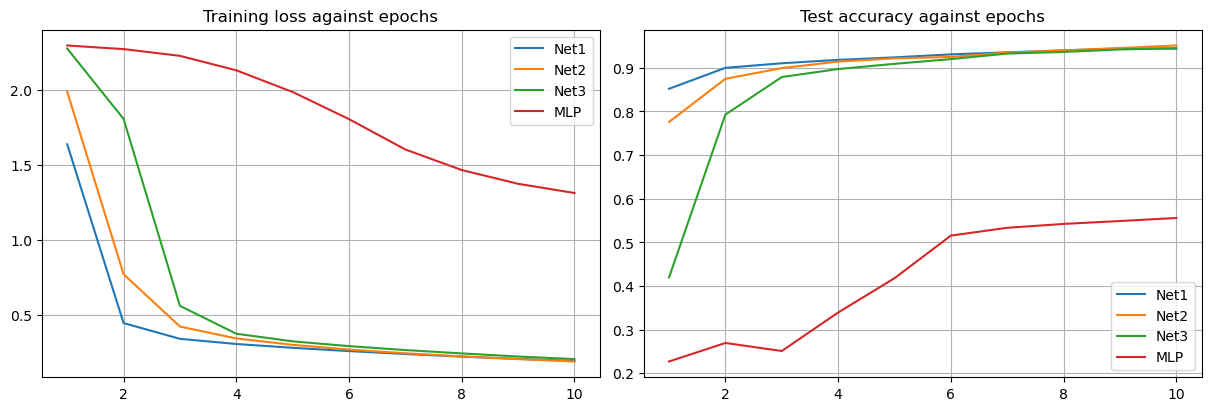

In [57]:
multiple_diagnostic(loss_acc_dict)
plt.savefig("./plots/mnist-benchmark-nets.pdf")

# Exercise 2

Try different optimizers with Net2 architecture

In [59]:
sgd_dict = {}
sgd_dict["SGD"] = loss_acc_dict["Net2"]

Add momentum term

In [61]:
model2_2 = Net2()
model2_2.to(device)

model2_2_dict = dict(model=model2_2, criterion=criterion, device=device, lr=0.001, momentum=0.9,
                     max_epochs=max_epochs,do_test=True)

stats = train_loop(train_loader, test_loader, **model2_2_dict)
sgd_dict["SGDM"] = [stats[0], stats[3]]

Epoch: 1, Learning rate: 0.001000
Training - Loss: 0.6002, Accuracy: 0.83, Runtime: 5.15
Test - Loss: 0.1956, Accuracy: 0.94
Epoch: 2, Learning rate: 0.001000
Training - Loss: 0.1606, Accuracy: 0.95, Runtime: 5.24
Test - Loss: 0.1157, Accuracy: 0.97
Epoch: 3, Learning rate: 0.001000
Training - Loss: 0.1043, Accuracy: 0.97, Runtime: 5.27
Test - Loss: 0.0842, Accuracy: 0.97
Epoch: 4, Learning rate: 0.001000
Training - Loss: 0.0808, Accuracy: 0.98, Runtime: 5.20
Test - Loss: 0.0646, Accuracy: 0.98
Epoch: 5, Learning rate: 0.001000
Training - Loss: 0.0686, Accuracy: 0.98, Runtime: 5.15
Test - Loss: 0.0689, Accuracy: 0.98
Epoch: 6, Learning rate: 0.001000
Training - Loss: 0.0591, Accuracy: 0.98, Runtime: 5.23
Test - Loss: 0.0550, Accuracy: 0.98
Epoch: 7, Learning rate: 0.001000
Training - Loss: 0.0525, Accuracy: 0.98, Runtime: 5.14
Test - Loss: 0.0489, Accuracy: 0.98
Epoch: 8, Learning rate: 0.001000
Training - Loss: 0.0474, Accuracy: 0.99, Runtime: 5.11
Test - Loss: 0.0470, Accuracy: 0.98


Change batch size

In [62]:
train_loader2 = torch.utils.data.DataLoader(trainset, num_workers=2, pin_memory=True, shuffle=True, batch_size=128)
test_loader2 = torch.utils.data.DataLoader(testset, num_workers=2, pin_memory=True, shuffle=True, batch_size=128)

model2_3 = Net2()
model2_3.to(device)

model2_3_dict = dict(model=model2_3, criterion=criterion, device=device, lr=0.001, momentum=0.9,
                     max_epochs=max_epochs, do_test=True)

stats = train_loop(train_loader2, test_loader2, **model2_3_dict)
sgd_dict["SGD2"] = [stats[0], stats[3]]

Epoch: 1, Learning rate: 0.001000
Training - Loss: 0.8681, Accuracy: 0.77, Runtime: 4.84
Test - Loss: 0.3002, Accuracy: 0.91
Epoch: 2, Learning rate: 0.001000
Training - Loss: 0.2554, Accuracy: 0.92, Runtime: 4.87
Test - Loss: 0.1884, Accuracy: 0.94
Epoch: 3, Learning rate: 0.001000
Training - Loss: 0.1764, Accuracy: 0.95, Runtime: 4.92
Test - Loss: 0.1346, Accuracy: 0.96
Epoch: 4, Learning rate: 0.001000
Training - Loss: 0.1339, Accuracy: 0.96, Runtime: 4.78
Test - Loss: 0.1072, Accuracy: 0.97
Epoch: 5, Learning rate: 0.001000
Training - Loss: 0.1088, Accuracy: 0.97, Runtime: 5.80
Test - Loss: 0.0910, Accuracy: 0.97
Epoch: 6, Learning rate: 0.001000
Training - Loss: 0.0940, Accuracy: 0.97, Runtime: 6.03
Test - Loss: 0.0799, Accuracy: 0.98
Epoch: 7, Learning rate: 0.001000
Training - Loss: 0.0827, Accuracy: 0.98, Runtime: 5.47
Test - Loss: 0.0722, Accuracy: 0.98
Epoch: 8, Learning rate: 0.001000
Training - Loss: 0.0758, Accuracy: 0.98, Runtime: 5.95
Test - Loss: 0.0769, Accuracy: 0.97


Increase learning rate

In [63]:
model2_4 = Net2()
model2_4.to(device)

model2_4_dict = dict(model=model2_4, criterion=criterion, device=device, lr=0.01, momentum=0.9,
                     max_epochs=max_epochs, do_test=True)

stats = train_loop(train_loader, test_loader, **model2_4_dict)
sgd_dict["SGDM2"] = [stats[0], stats[3]]

Epoch: 1, Learning rate: 0.010000
Training - Loss: 0.2008, Accuracy: 0.94, Runtime: 5.39
Test - Loss: 0.0497, Accuracy: 0.98
Epoch: 2, Learning rate: 0.010000
Training - Loss: 0.0523, Accuracy: 0.98, Runtime: 5.39
Test - Loss: 0.0368, Accuracy: 0.99
Epoch: 3, Learning rate: 0.010000
Training - Loss: 0.0364, Accuracy: 0.99, Runtime: 5.44
Test - Loss: 0.0316, Accuracy: 0.99
Epoch: 4, Learning rate: 0.010000
Training - Loss: 0.0271, Accuracy: 0.99, Runtime: 5.14
Test - Loss: 0.0293, Accuracy: 0.99
Epoch: 5, Learning rate: 0.010000
Training - Loss: 0.0226, Accuracy: 0.99, Runtime: 5.39
Test - Loss: 0.0270, Accuracy: 0.99
Epoch: 6, Learning rate: 0.010000
Training - Loss: 0.0172, Accuracy: 0.99, Runtime: 5.53
Test - Loss: 0.0262, Accuracy: 0.99
Epoch: 7, Learning rate: 0.010000
Training - Loss: 0.0128, Accuracy: 1.00, Runtime: 5.58
Test - Loss: 0.0236, Accuracy: 0.99
Epoch: 8, Learning rate: 0.010000
Training - Loss: 0.0105, Accuracy: 1.00, Runtime: 5.56
Test - Loss: 0.0273, Accuracy: 0.99


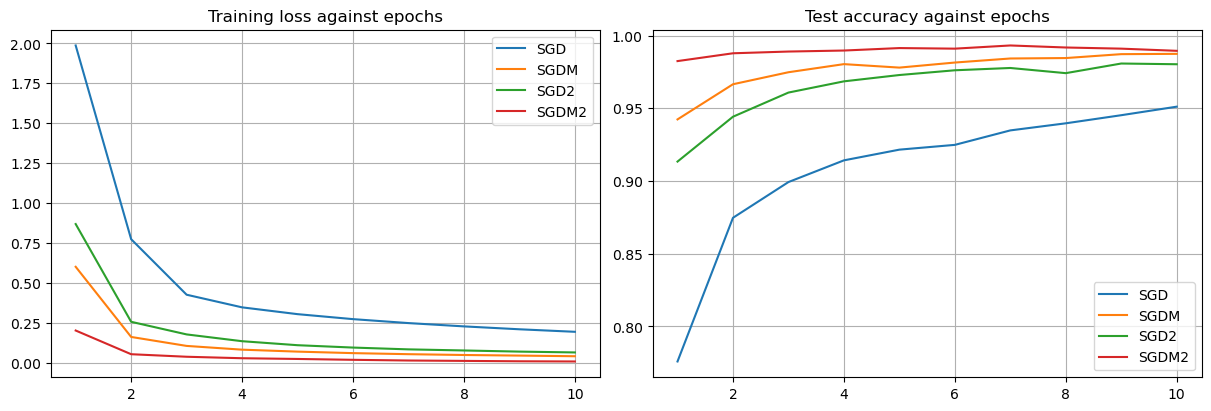

In [64]:
multiple_diagnostic(sgd_dict)
plt.savefig("./plots/mnist-benchmark-opts.pdf")